In [58]:
import pandas as pd

from libraries.client_stashapp import get_stashapp_client

stash = get_stashapp_client()

def get_parent_studio_id(studio):
    if studio["parent_studio"] is not None:
        return studio["parent_studio"]["id"]
    return None

studios = stash.find_studios({})
df_studios = pd.DataFrame(studios)
df_studios["parent_studio_id"] = df_studios.apply(get_parent_studio_id, axis=1)

use_studio_code_tag = stash.find_tag("Filenames: Use Studio Code")

performers = stash.find_performers({})
df_performers = pd.DataFrame(performers)

# Lookup functions
def get_by_parent_studio(parent_studio_id):
    return df_studios[df_studios["parent_studio_id"] == parent_studio_id]

def get_studio(studio_id):
    return df_studios[df_studios["id"] == studio_id]

def get_studio_by_name(studio_name):
    return df_studios[df_studios["name"] == studio_name]

def get_performer(performer_id):
    return df_performers[df_performers["id"] == performer_id]

dUsing stash (v0.27.2-6-g446e99ae) endpoint at https://stash.chiefsclub.com:443/graphql
dPersisting Connection to Stash with ApiKey...


In [59]:
videos_paths = ["W:\\Culture\\Videos", "X:\\Culture\\Videos", "Y:\\Culture\\Videos", "Z:\\Culture\\Videos"]

stash.metadata_scan(videos_paths, {
    "scanGenerateClipPreviews": False,
    "scanGenerateCovers": True,
    "scanGenerateImagePreviews": False,
    "scanGeneratePhashes": True,
    "scanGeneratePreviews": False,
    "scanGenerateSprites": False,
    "scanGenerateThumbnails": False
})

'9'

In [60]:
current_studios = get_by_parent_studio("425")
# current_studios = get_parent_studio_by_name("Babes")
current_studio_ids = current_studios["id"].to_list()

current_studios

,id,name,url,parent_studio,child_studios,aliases,tags,ignore_auto_tag,image_path,scene_count,...,performer_count,group_count,stash_ids,rating100,favorite,details,created_at,updated_at,groups,parent_studio_id
98,41,Babes,https://www.babes.com/,{'id': '425'},[],[],"[{'id': '7940', 'name': 'Filenames: Use Studio...",False,https://stash.chiefsclub.com/studio/41/image?t...,212,...,218,0,"[{'endpoint': 'https://stashdb.org/graphql', '...",NaN,False,,2023-01-28T04:11:27Z,2024-10-19T07:16:14+03:00,[],425
100,884,Babes Unleashed,https://www.babes.com/scenes?site=218,{'id': '425'},[],[],"[{'id': '7940', 'name': 'Filenames: Use Studio...",False,https://stash.chiefsclub.com/studio/884/image?...,2,...,2,0,"[{'endpoint': 'https://stashdb.org/graphql', '...",NaN,False,,2024-04-09T07:52:48Z,2024-10-19T07:53:42+03:00,[],425
152,761,Black Is Better,,{'id': '425'},[],[],"[{'id': '7940', 'name': 'Filenames: Use Studio...",False,https://stash.chiefsclub.com/studio/761/image?...,18,...,19,0,"[{'endpoint': 'https://stashdb.org/graphql', '...",NaN,False,,2024-02-29T03:42:53Z,2024-10-19T07:53:52+03:00,[],425
325,90,Elegant Anal,https://www.babes.com/scenes?site=216,{'id': '425'},[],[],"[{'id': '7940', 'name': 'Filenames: Use Studio...",False,https://stash.chiefsclub.com/studio/90/image?t...,26,...,37,0,"[{'endpoint': 'https://stashdb.org/graphql', '...",NaN,False,,2023-01-30T04:48:17Z,2024-10-19T07:54:00+03:00,[],425
770,146,Office Obsession,https://www.babes.com/scenes?site=214,{'id': '425'},[],[],"[{'id': '7940', 'name': 'Filenames: Use Studio...",False,https://stash.chiefsclub.com/studio/146/image?...,11,...,20,0,"[{'endpoint': 'https://stashdb.org/graphql', '...",NaN,False,,2023-01-31T04:15:34Z,2024-10-19T07:54:08+03:00,[],425
973,426,Step Mom Lessons,https://www.babes.com/scenes?site=215,{'id': '425'},[],[],"[{'id': '7940', 'name': 'Filenames: Use Studio...",False,https://stash.chiefsclub.com/studio/426/image?...,29,...,59,0,"[{'endpoint': 'https://stashdb.org/graphql', '...",NaN,False,,2024-02-02T08:17:12Z,2024-10-19T07:54:15+03:00,[],425


In [61]:
# Find scenes with specific title
# scenes_data = stash.find_scenes({ "title": { "value": "sucker", "modifier": "INCLUDES" } }, filter={ "per_page": 40, "page": 1, "sort": "date", "direction": "DESC" })
# scenes_data = stash.find_scenes({ "performers": { "value": ["210"], "excludes": [], "modifier": "INCLUDES_ALL" } }, filter={ "per_page": 120, "page": 6, "sort": "path", "direction": "DESC" })
scenes_data = stash.find_scenes(
    {
        "studios": { "value": current_studio_ids, "excludes": [], "modifier": "INCLUDES" },
        # "stash_id_endpoint": { "endpoint": "", "stash_id": "", "modifier": "NOT_NULL" },
        # "studios": { "value": [], "excludes": [], "modifier": "NOT_NULL" },
        "performers": { "value": [], "excludes": [], "modifier": "NOT_NULL" }
    },
    filter={ "per_page": 1000, "page": 1, "sort": "created_at", "direction": "DESC" },
    fragment="id title code date files { id path basename fingerprints { type value } format width height video_codec frame_rate } studio { id name tags { id name } } performers { id name gender tags { id name} }"
)
scenes_df = pd.DataFrame(scenes_data)
print(len(scenes_df))

298


In [67]:
def get_path(files):
    return files[0]["path"] if files else None

def get_basename(files):
    return files[0]["basename"] if files else None

def get_first_file_resolution(files):
    return str(files[0]["width"]) + "x" + str(files[0]["height"]) if files else None

def get_studio_value(studio):
    if (studio is None):
        return "Unknown Studio"

    stash_studio = get_studio(studio["id"])
    if stash_studio.empty:
        return "Unknown Studio"
    
    parent_stash_studio = get_studio(stash_studio["parent_studio_id"].iloc[0])
    if not parent_stash_studio.empty:
        return parent_stash_studio["name"].iloc[0] + "꞉ " + stash_studio["name"].iloc[0]

    return stash_studio["name"].iloc[0]

def get_use_studio_code(studio):
    if studio is None:
        return False

    stash_studio = get_studio(studio["id"])
    

    parent_stash_studio = get_studio(studio["parent_studio_id"])
    if not parent_stash_studio.empty:
        parent_studio_tags_ids = [tag["id"] for tag in parent_stash_studio["tags"]]
        if use_studio_code_tag["id"] in parent_studio_tags_ids:
            return True

    studio_tags_ids = [tag["id"] for tag in studio["tags"]]    
    return use_studio_code_tag["id"] in studio_tags_ids

def get_performers(performers):
    return _get_performers(performers)

def get_non_male_performers(performers):
    return _get_performers(performers, 3)

def _get_performers(performers, exclude_gender = None):
    if len(performers) == 0:
        return "Unknown performers"

    stash_performers = []
    for performer in performers:
        stash_performer = get_performer(performer["id"])
        if not stash_performer.empty:
            stash_performers.append(stash_performer)
        else:
            raise Exception("Performer not found with ID: " + performer["id"])
    
    # Concatenate the data frames into a single data frame
    df_stash_performers = pd.concat(stash_performers)

    # Sort by gender with a custom order and then by name
    # Define a custom sort order for gender
    gender_priority = {
        'TRANSGENDER_FEMALE': 1,
        'FEMALE': 2,
        'MALE': 3
    }
    
    # Map the 'gender' column to these priorities
    df_stash_performers['gender_priority'] = df_stash_performers['gender'].map(gender_priority).fillna(4)  # Any undefined genders get a default value

    # Now sort by this priority, and then by name
    
    df_stash_performers.sort_values(by=['gender_priority', 'name'], inplace=True)
    
    if exclude_gender is not None:
        result = ', '.join(df_stash_performers[df_stash_performers['gender_priority'] != exclude_gender]['name'])
    else:
        result = ', '.join(df_stash_performers['name'])

    # Cleanup: remove the auxiliary 'gender_priority' column if no longer needed
    df_stash_performers.drop('gender_priority', axis=1, inplace=True)

    return result

# Define a function to get the first file if available
def get_suffix(files):
    first_file = files[0]["basename"] if files else None
    file_suffix = os.path.splitext(first_file)[1] if first_file else None
    return file_suffix

def title_case_except_acronyms(text):
    words = text.split()
    title_cased_words = []
    for word in words:
        # Check if the word contains an apostrophe
        if "'" in word:
            # Split the word at the apostrophe and process each part
            parts = word.split("'")
            new_parts = [parts[0].title()]  # Always capitalize the part before the apostrophe
            if len(parts) > 1:
                # Never capitalize after the apostrophe
                new_parts.append(parts[1])
            # Rejoin the parts with an apostrophe
            title_cased_words.append("'".join(new_parts))
        else:
            # Apply the original logic if there's no apostrophe
            title_cased_words.append(word if word.isupper() and len(word) > 1 else word.title())

    return ' '.join(title_cased_words)

def clean_title(title):
    title = title_case_except_acronyms(title)
    return title.replace(":", "꞉").replace("?", "？").replace("/", "∕").replace("\\", "＼").replace("*", "＊").replace("\"", "＂").replace("<", "＜").replace(">", "＞").replace("|", "｜").replace("  ", " ")

import os
import re

def convert_stash_path_to_windows_path(files):
    # Check if files is not empty and contains a dictionary with a "path" key
    if not files or "path" not in files[0]:
        return None
    
    return files[0]["path"]

def get_xxhash(files):
    if not files or "fingerprints" not in files[0]:
        return None
    
    for fp in files[0]["fingerprints"]:
        if fp["type"] == "xxhash":
            return fp["value"]
    
    return None


# Apply the function to the 'files' column
scenes_df['path'] = scenes_df['files'].apply(get_basename)
scenes_df['windows_path'] = scenes_df['files'].apply(convert_stash_path_to_windows_path)
scenes_df['windows_directory'] = scenes_df['files'].apply(lambda files: os.path.dirname(convert_stash_path_to_windows_path(files)))
scenes_df['basename'] = scenes_df['files'].apply(get_basename)
scenes_df['resolution'] = scenes_df['files'].apply(get_first_file_resolution)
scenes_df['primary_studio'] = scenes_df['studio'].apply(get_studio_value)
scenes_df['use_studio_code'] = scenes_df['studio'].apply(get_use_studio_code)
scenes_df['performers_str'] = scenes_df['performers'].apply(get_performers)
scenes_df['non_male_performers_str'] = scenes_df['performers'].apply(get_non_male_performers)
scenes_df['suffix'] = scenes_df['files'].apply(get_suffix)
scenes_df['xxhash'] = scenes_df['files'].apply(get_xxhash)

# Create filename, print out the files without xxhash

MAX_LENGTH = 255

# Assuming scenes_df and the function clean_title are defined
scenes_df['fs_title'] = scenes_df['title'].apply(clean_title)

def clean_for_filename(input):
    input = title_case_except_acronyms(input)
    return input.replace(":", "꞉").replace("?", "？").replace("/", "∕").replace("\\", "＼").replace("*", "＊").replace("\"", "＂").replace("<", "＜").replace(">", "＞").replace("|", "｜").replace("  ", " ")

def create_filename(row):
    xxhash = row['xxhash']
    xxhash_fmt = " [" + str(xxhash) + "]"

    suffix_length = len(row['suffix']) if row['suffix'] else 0
    xxhash_length = len(xxhash_fmt)
    max_length_wo_xxhash_suffix = MAX_LENGTH - xxhash_length - suffix_length

    # Choose between full performers string or a limited one based on the current combination length
    performers_str = row['performers_str']
    base_filename = f"{row['primary_studio']} – {row['date']} – "
    
    if row['use_studio_code'] and row['code']:
        base_filename += f"{clean_for_filename(row['code'])} – "
    
    base_filename += clean_for_filename(f"{row['fs_title']} – {performers_str}")

    # Check if the generated filename exceeds the maximum length
    if len(base_filename) + len(row['suffix']) > max_length_wo_xxhash_suffix:
        # Use non_male_performers_str if the full string is too long
        performers_str = row['non_male_performers_str']
        base_filename = f"{row['primary_studio']} – {row['date']} – "
        
        if row['use_studio_code'] and row['code']:
            base_filename += f"{clean_for_filename(row['code'])} – "
        
        base_filename += clean_for_filename(f"{row['fs_title']} – {performers_str}")

    return base_filename + xxhash_fmt + row['suffix']

scenes_df['new_filename'] = scenes_df.apply(create_filename, axis=1)

scenes_df['new_path'] = scenes_df['windows_directory'] + '\\' + scenes_df['new_filename']
scenes_df['new_path'] = scenes_df['new_path'].apply(lambda x: os.path.normpath(x))
scenes_df['windows_path'] = scenes_df['windows_path'].apply(lambda x: os.path.normpath(x))


KeyError: 'parent_studio_id'

In [63]:
scenes_df[scenes_df['xxhash'].isnull()]

,id,title,code,date,files,studio,performers,path,windows_path,windows_directory,...,resolution,primary_studio,use_studio_code,performers_str,non_male_performers_str,suffix,xxhash,fs_title,new_filename,new_path


In [64]:
renames_df = scenes_df.copy()
renames_df = renames_df.loc[renames_df['xxhash'].notnull()]
renames_df = renames_df.loc[renames_df['new_path'].notnull()]
renames_df = renames_df.loc[renames_df['windows_path'] != renames_df['new_path']]
renames_df = renames_df[['windows_path', 'new_path', 'xxhash']]
renames_df = renames_df.sort_values(by='windows_path')
renames_df['new_path'].to_list()

['X:\\Culture\\Videos\\Sites\\Babes (Network)\\Babes (Network)꞉ Babes Unleashed\\Babes (Network)꞉ Babes Unleashed – 2016-12-16 – 3083611 – Fan Service – Lena Paul, Michael Vegas [3a49953492258a25].mp4',
 'X:\\Culture\\Videos\\Sites\\Babes (Network)\\Babes (Network)꞉ Babes\\Babes (Network)꞉ Babes Unleashed – 2016-12-16 – 3083611 – Fan Service – Lena Paul, Michael Vegas [f53d6ed7b826f1ea].mp4',
 'X:\\Culture\\Videos\\Sites\\Babes (Network)\\Babes (Network)꞉ Babes\\Babes (Network)꞉ Black Is Better – 2016-01-19 – 3094351 – Recital Of Her Dreams – Melissa Moore, Ricky Johnson [263664756d10325e].mp4',
 'X:\\Culture\\Videos\\Sites\\Babes (Network)\\Babes (Network)꞉ Babes\\Babes (Network)꞉ Black Is Better – 2016-04-12 – 3092981 – Layover Lust – Anna De Ville, Jax Slayher [10f36e37237d9276].mp4',
 'X:\\Culture\\Videos\\Sites\\Babes (Network)\\Babes (Network)꞉ Babes\\Babes (Network)꞉ Elegant Anal – 2014-07-12 – 3100111 – Come In My Back Door – Ivana Sugar, Victor Solo [de04260cf8a8e511].mp4',
 '

In [65]:
scenes_df[['windows_path', 'new_path', 'xxhash']]

,windows_path,new_path,xxhash
0,X:\Culture\Videos\Sites\Babes (Network)\Babes ...,X:\Culture\Videos\Sites\Babes (Network)\Babes ...,3ef859d48dd010a0
1,X:\Culture\Videos\Sites\Babes (Network)\Babes ...,X:\Culture\Videos\Sites\Babes (Network)\Babes ...,1ead664eea70b906
2,X:\Culture\Videos\Sites\Babes (Network)\Babes ...,X:\Culture\Videos\Sites\Babes (Network)\Babes ...,1221fe26f7d58b87
3,X:\Culture\Videos\Sites\Babes (Network)\Babes ...,X:\Culture\Videos\Sites\Babes (Network)\Babes ...,14ec8baf959b8987
4,X:\Culture\Videos\Sites\Babes (Network)\Babes ...,X:\Culture\Videos\Sites\Babes (Network)\Babes ...,3475e150bbc44d4c
...,...,...,...
293,X:\Culture\Videos\Sites\Babes (Network)\Babes ...,X:\Culture\Videos\Sites\Babes (Network)\Babes ...,6430c51bc99cc61e
294,X:\Culture\Videos\Sites\Babes (Network)\Babes ...,X:\Culture\Videos\Sites\Babes (Network)\Babes ...,7d6ad2a18764c07f
295,X:\Culture\Videos\Sites\Babes (Network)\Babes ...,X:\Culture\Videos\Sites\Babes (Network)\Babes ...,0466b1e6910d7c86
296,X:\Culture\Videos\Sites\Babes (Network)\Babes ...,X:\Culture\Videos\Sites\Babes (Network)\Babes ...,7846845154a877b8


In [66]:
import os
import pandas as pd

# Assuming renames_df is already defined and has columns 'windows_path', 'new_path', 'xxhash'

# Initialize empty DataFrames for success and failure results
success_df = pd.DataFrame(columns=renames_df.columns)
failed_df = pd.DataFrame(columns=renames_df.columns)

for index, row in renames_df.iterrows():
    old_path = row['windows_path']
    new_path = row['new_path']

    # Check for missing hash or new path
    if pd.isna(row['xxhash']):
        print(f"XXHash not found for {old_path}")
        failed_df = pd.concat([failed_df, pd.DataFrame([row])], ignore_index=True)
        continue
    if pd.isna(new_path):
        print(f"New path not found for {old_path}")
        failed_df = pd.concat([failed_df, pd.DataFrame([row])], ignore_index=True)
        continue

    # Attempt to move the file if the old path is a file and the new path does not exist
    if os.path.isfile(old_path):
        if not os.path.exists(new_path):
            try:
                os.rename(old_path, new_path)

                # Check for and rename AI JSON sidecar file if it exists
                ai_json_path = f"{old_path}.AI.json"
                if os.path.isfile(ai_json_path):
                    new_ai_json_path = f"{new_path}.AI.json"
                    try:
                        os.rename(ai_json_path, new_ai_json_path)
                        print(f"Renamed AI JSON sidecar file:\n{ai_json_path}\n{new_ai_json_path}")
                    except Exception as e:
                        print(f"Failed to rename AI JSON sidecar file:\n{ai_json_path}\n{new_ai_json_path}\n{e}")
                print(f"Rename file:\n{old_path}\n{new_path}\n")
                success_df = pd.concat([success_df, pd.DataFrame([row])], ignore_index=True)
            except Exception as e:
                print(f"Failed to rename:\n{old_path}\n{new_path}\n{e}")
                failed_df = pd.concat([failed_df, pd.DataFrame([row])], ignore_index=True)
        else:
            print(f"A file already exists in the new path: {new_path}")
            failed_df = pd.concat([failed_df, pd.DataFrame([row])], ignore_index=True)
    else:
        print(f"File does not exist: {old_path}")
        failed_df = pd.concat([failed_df, pd.DataFrame([row])], ignore_index=True)

len(renames_df) == len(success_df)


Rename file:
X:\Culture\Videos\Sites\Babes (Network)\Babes (Network)꞉ Babes Unleashed\Babes (Network)꞉ Babes Unleashed – 2016-12-16 – Fan Service – Lena Paul, Michael Vegas [3a49953492258a25].mp4
X:\Culture\Videos\Sites\Babes (Network)\Babes (Network)꞉ Babes Unleashed\Babes (Network)꞉ Babes Unleashed – 2016-12-16 – 3083611 – Fan Service – Lena Paul, Michael Vegas [3a49953492258a25].mp4

Rename file:
X:\Culture\Videos\Sites\Babes (Network)\Babes (Network)꞉ Babes\Babes (Network)꞉ Babes Unleashed – 2016-12-16 – Fan Service – Lena Paul, Michael Vegas [f53d6ed7b826f1ea].mp4
X:\Culture\Videos\Sites\Babes (Network)\Babes (Network)꞉ Babes\Babes (Network)꞉ Babes Unleashed – 2016-12-16 – 3083611 – Fan Service – Lena Paul, Michael Vegas [f53d6ed7b826f1ea].mp4

Rename file:
X:\Culture\Videos\Sites\Babes (Network)\Babes (Network)꞉ Babes\Babes (Network)꞉ Black Is Better – 2016-01-19 – Recital Of Her Dreams – Melissa Moore, Ricky Johnson [263664756d10325e].mp4
X:\Culture\Videos\Sites\Babes (Network)\

True

In [ ]:
success_df

,windows_path,new_path,xxhash
0,Y:\Culture\Videos\Sites\Vixen Media Group\Tush...,Y:\Culture\Videos\Sites\Vixen Media Group\Tush...,da6ae6b47b51b95b
1,Y:\Culture\Videos\Spermmania.Alexis.Crystal.Us...,Y:\Culture\Videos\Digital J Media꞉ Sperm Mania...,fd1c27a4c08c176d
2,Y:\Culture\Videos\Spermmania.Alexis.Crystals.P...,Y:\Culture\Videos\Digital J Media꞉ Sperm Mania...,bf23a109d5093cd1
3,Y:\Culture\Videos\alexis crystal spermmania-22...,Y:\Culture\Videos\Digital J Media꞉ Sperm Mania...,cc603649c4b555b4
4,Y:\Culture\Videos\spermmania-217.mp4,Y:\Culture\Videos\Digital J Media꞉ Sperm Mania...,83c1d1ae6a48fcb8
5,Y:\Culture\Videos\spermmania-220.mp4,Y:\Culture\Videos\Digital J Media꞉ Sperm Mania...,5088a75d3c52681c
6,Y:\Culture\Videos\spermmania-223.mp4,Y:\Culture\Videos\Digital J Media꞉ Sperm Mania...,0f55b47d5eafeb27
7,Z:\Culture\Videos\CHECKED\279-czechvr-3d-2880x...,Z:\Culture\Videos\CHECKED\Czech VR Network꞉ Cz...,e7dc1af85a1e4699
8,Z:\Culture\Videos\CHECKED\Alexis Crystal SZ173...,Z:\Culture\Videos\CHECKED\Anal Vids꞉ Gonzo – 2...,d6b0201da51da481
9,Z:\Culture\Videos\CHECKED\AlexisCrystalCollect...,Z:\Culture\Videos\CHECKED\1 Pass for All Sites...,e0be33116af809d4


In [172]:
failed_df

,windows_path,new_path,xxhash
0,Y:\Culture\Videos\Sites\Vixen Media Group\Deep...,Y:\Culture\Videos\Sites\Vixen Media Group\Deep...,9b289d58a557fb2a


In [51]:
import difflib

# Assuming failed_renames_df and failed_df are defined
failed_renames_df = renames_df[renames_df['xxhash'].isin(failed_df['xxhash'])].copy()

def format_diff(old, new):
    diff = list(difflib.ndiff(old, new))
    formatted_diff = ''.join(diff)
    return formatted_diff

failed_renames_df['diff'] = failed_renames_df.apply(lambda row: format_diff(row['windows_path'], row['new_path']), axis=1)


Non-renaming things start from here.

In [46]:
# Find female performers
female_performers = stash.find_performers({ "gender": { "value": "FEMALE", "modifier": "EQUALS" } })
df_female_performers = pd.DataFrame(female_performers)
df_female_performers['birthdate'] = pd.to_datetime(df_female_performers['birthdate'])

In [47]:
favorite_performers = stash.find_performers({ "filter_favorites": True })
df_favorite_performers = pd.DataFrame(favorite_performers)
df_favorite_performers['birthdate'] = pd.to_datetime(df_favorite_performers['birthdate'])

In [48]:
from IPython.display import Image
from IPython.display import display

# Assuming df is your DataFrame and 'image_path' is your column with URLs
x = Image(url= df_favorite_performers['image_path'][0]) 
display(x)

In [33]:
%pip install matplotlib

     ---------------------------------------- 0.0/162.2 kB ? eta -:--:--
     -- ------------------------------------- 10.2/162.2 kB ? eta -:--:--
     -------------- ------------------------ 61.4/162.2 kB 1.1 MB/s eta 0:00:01
     -------------------------------------- 162.2/162.2 kB 1.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   ---- ----------------------------------- 0.9/7.6 MB 29.7 MB/s eta 0:00:01
   ------------ --------------------------- 2.4/7.6 MB 37.7 MB/s eta 0:00:01
   ------------------- -------------------- 3.8/7.6 MB 40.1 MB/s eta 0:00:01
   --------------------------- ------------ 5.2/7.6 MB 36.7 MB/s eta 0:00:01
   ---------------------------------- ----- 6.7/7.6 MB 38.8 MB/s eta 0:00:01
   ---------------------------------------  7.6/7.6 MB 37.6 MB/s eta 0:00:01
   ---------------------------------------- 7.6/7.6 MB 34.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/187.7 kB ? eta -:--:--
   -----------

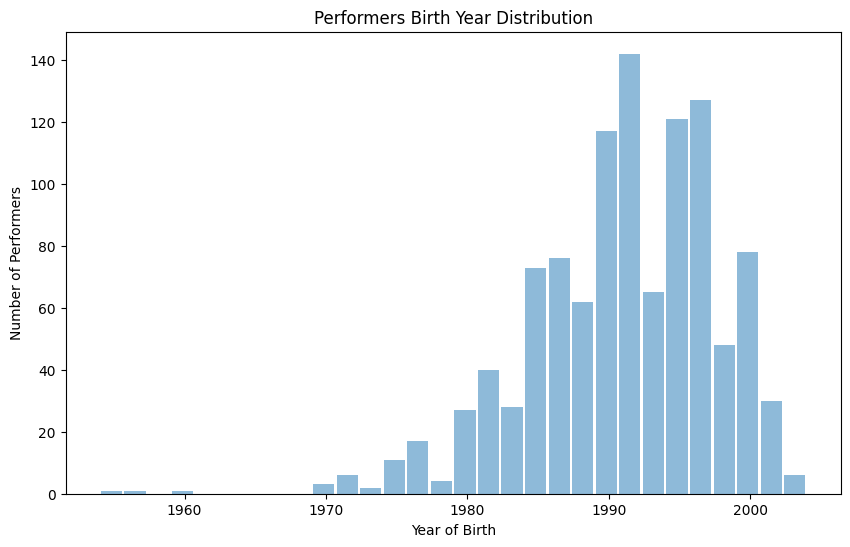

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
df_female_performers['birthdate'].dt.year.hist(bins=30, alpha=0.5, rwidth=0.9)
plt.xlabel('Year of Birth')
plt.ylabel('Number of Performers')
plt.title('Performers Birth Year Distribution')
plt.grid(False)
plt.show()

In [ ]:
# Find scenes with specific performer
scenes_data = stash.find_scenes({ "title": { "value": "erections", "modifier": "INCLUDES" } }, filter={ "per_page": 40, "page": 1, "sort": "date", "direction": "DESC" })
scenes_df = pd.DataFrame(scenes_data)